In [1]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader,random_split
import random
import os

In [2]:
def get_mean_std(dataloader, device='cuda'):
    """
    Compute dataset mean and std efficiently using a single pass.

    Args:
        dataloader: PyTorch DataLoader.
        device: 'cuda' or 'cpu' for computation.

    Returns:
        mean, std: Normalized mean and standard deviation tensors.
    """
    mean = torch.zeros(3, device=device)
    M2 = torch.zeros(3, device=device)  # Running sum of squared differences
    num_samples = 0

    for images, _ in tqdm(dataloader):
        images = images.to(device)  # Move batch to GPU
        batch_samples = images.size(0)  # Batch size

        batch_mean = images.mean(dim=(0, 2, 3))  # Compute mean per channel
        batch_var = images.var(dim=(0, 2, 3), unbiased=False)  # Variance (not std)

        mean += batch_mean * batch_samples
        M2 += batch_var * batch_samples
        num_samples += batch_samples

    mean /= num_samples
    std = torch.sqrt(M2 / num_samples)  # Convert variance to std

    print(f"Mean: {mean.tolist()}")
    print(f"Std: {std.tolist()}")
    return mean, std


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def get_channel_histograms_by_class(dataloader, bins=256):
    """
    Compute and plot histograms for each RGB channel in the dataset, separately for class 0 and class 1.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        bins (int): Number of histogram bins.

    Returns:
        histograms (dict): Nested dictionary with histograms by class and channel.
                           histograms[class][channel] = histogram
    """
    histograms = {
        0: {0: np.zeros(bins), 1: np.zeros(bins), 2: np.zeros(bins)},
        1: {0: np.zeros(bins), 1: np.zeros(bins), 2: np.zeros(bins)}
    }

    for images, labels in tqdm(dataloader):
        batch_size = images.shape[0]
        images = images.view(batch_size, 3, -1)  # Flatten to (B, C, H*W)

        for i in range(batch_size):
            label = int(labels[i].item())
            for c in range(3):  # Iterate over channels
                channel_data = images[i, c, :].cpu().numpy()
                values, _ = np.histogram(channel_data, bins=bins, range=(0, 1))
                histograms[label][c] += values

    # Normalize histograms per class and channel
    for cls in [0, 1]:
        for c in range(3):
            total = np.sum(histograms[cls][c])
            if total > 0:
                histograms[cls][c] /= total

    # Plot histograms
    colors = ['red', 'green', 'blue']
    for cls in [0, 1]:
        plt.figure(figsize=(12, 4))
        for c, color in enumerate(colors):
            plt.bar(np.linspace(0, 1, bins), histograms[cls][c], width=1/bins, alpha=0.5,
                    color=color, label=f'Channel {color}')
        plt.title(f'RGB Channel Intensity Histograms - Class {cls}')
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

    return histograms


In [4]:
# BASE_PATH = "/kaggle/input/mva-dlmi-2025-histopathology-ood-classification"
TRAIN_IMAGES_PATH = 'data/train.h5'
VAL_IMAGES_PATH = 'data/val.h5'
TEST_IMAGES_PATH = 'data/test.h5'
SEED = 0

In [5]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}

In [44]:
import random
import torchvision.transforms as transforms
import torch
import h5py
import numpy as np
from torch.utils.data import Dataset

class BaselineDataset(Dataset):
    def __init__(self, dataset_path, preprocessing=None, mode="train", augmentations=None, num_augmentations=1):
        super(BaselineDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        self.augmentations = augmentations
        self.num_augmentations = num_augmentations if mode == "train" else 1  # Only augment during training

        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())  # Original image IDs
        
        # Expand dataset size
        self.expanded_indices = [
            (idx, aug_idx) for idx in range(len(self.image_ids)) for aug_idx in range(self.num_augmentations)
        ]

    def __len__(self):
        return len(self.expanded_indices)

    def __getitem__(self, idx):
        img_idx, aug_idx = self.expanded_indices[idx]
        img_id = self.image_ids[img_idx]

        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(np.array(hdf.get(img_id).get('img')))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else -1
        
        # Apply standard preprocessing
        if self.preprocessing is not None:
            img = self.preprocessing(img)

        # Apply augmentation
        if self.augmentations is not None and self.mode == "train":
            img = self.augmentations(img)
        
        
        
        return img.float(), torch.tensor(label, dtype=torch.float32)

In [45]:

class AddGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0.0, std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0.0, 1.0)

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"


In [46]:
import torch.nn.functional as Fnn
import torch

class Sharpen(torch.nn.Module):
    def forward(self, x):
        x = x.float() / 255.0 if x.max() > 1 else x.float()  # normalize if needed
        kernel = torch.tensor([[[[0, -1,  0],
                                 [-1,  5, -1],
                                 [0, -1,  0]]]], dtype=torch.float32, device=x.device)
        kernel = kernel.repeat(x.shape[0], 1, 1, 1)
        x = x.unsqueeze(0) if x.dim() == 3 else x
        x = Fnn.conv2d(x, kernel, padding=1, groups=x.shape[1]).squeeze(0)
        return torch.clamp(x, 0, 1)



In [47]:
train_augmentations = transforms.Compose([
    # transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomAffine(3, shear=0.05),
    transforms.RandomApply([AddGaussianNoise(mean=0.0, std=0.1)], p=0.5),
    transforms.RandomApply([    
        transforms.ColorJitter(brightness=[0.5,1.05], saturation=[1,1.60], contrast=[1,1.6], hue=0.1)], p=0.5),
    transforms.RandomGrayscale(p=0.1),
])

train_preprocessing = transforms.Compose([
    transforms.Resize((224,224)),
    Sharpen()
    # transforms.Normalize(mean = [0.485, 0.456, 0.406],
    #                         std = [0.229, 0.224, 0.225])
    # transforms.Grayscale(num_output_channels=3)
])

train_set = BaselineDataset(TRAIN_IMAGES_PATH, preprocessing=train_preprocessing, augmentations=train_augmentations, num_augmentations=1)
train_set,_ = random_split(train_set, [30000, len(train_set) - 30000])
val_set = BaselineDataset(VAL_IMAGES_PATH, preprocessing=train_preprocessing)
test_set = BaselineDataset(TEST_IMAGES_PATH, preprocessing=train_preprocessing, mode="test")

train_loader = DataLoader(train_set, batch_size=256, shuffle = False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle = False)
test_loader = DataLoader(test_set, batch_size=256, shuffle = False)

In [ ]:
hists = get_channel_histograms_by_class(train_loader)

In [ ]:
m,s = get_mean_std(train_loader)

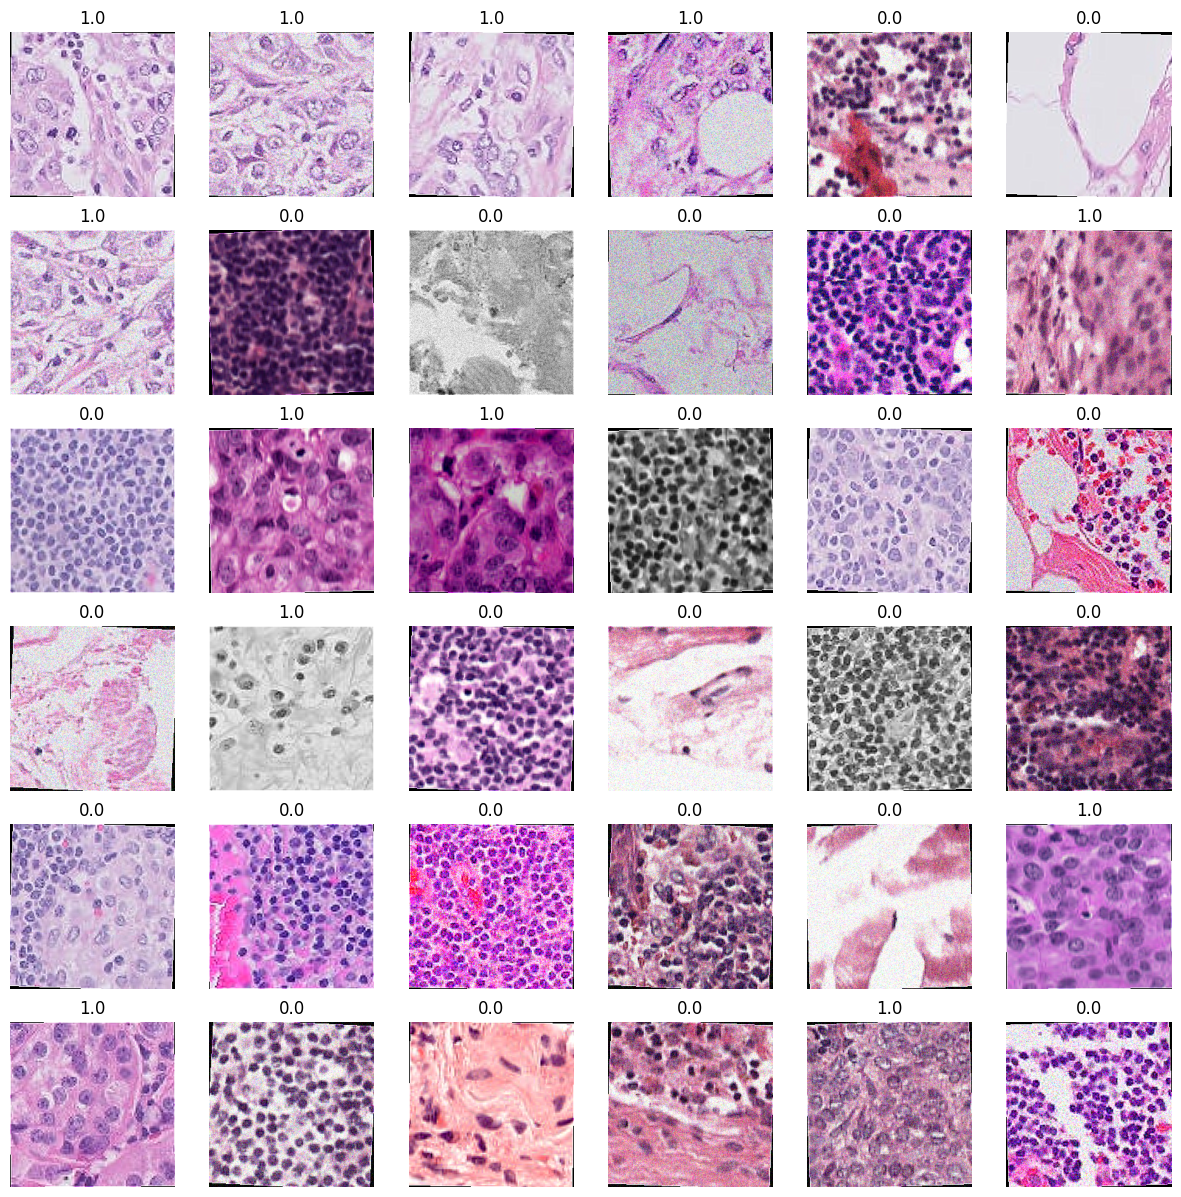

In [48]:
fig,axs = plt.subplots(6,6, figsize=(15,15))
for k,i in enumerate(np.random.choice(np.arange(len(train_set)), size = len(axs.flatten()), replace = False)):
    img, label = train_set.__getitem__(i)
    img = (img - img.min())/(img.max() - img.min())
    # print(np.moveaxis(img.numpy(), 0, -1))
    axs.flatten()[k].imshow(np.moveaxis(img.numpy(), 0, -1).astype(np.float32))
    axs.flatten()[k].set_title(str(label.item()))
    axs.flatten()[k].axis("off")
plt.show()

100%|██████████| 137/137 [01:40<00:00,  1.36it/s]


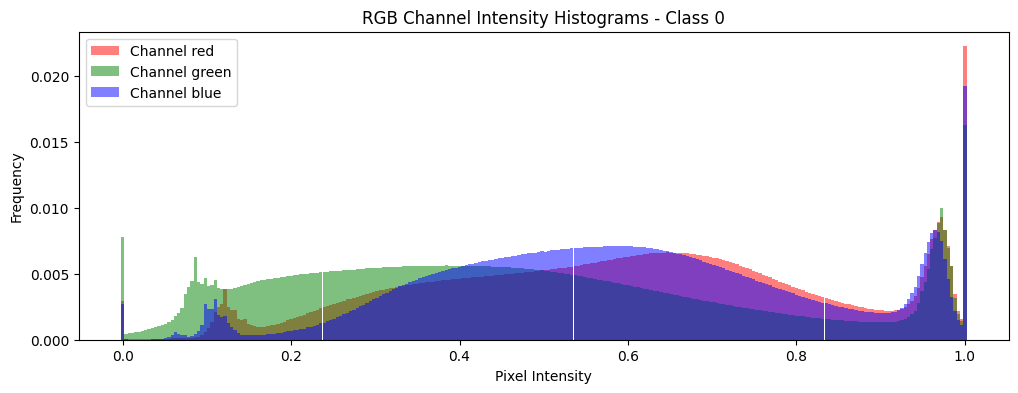

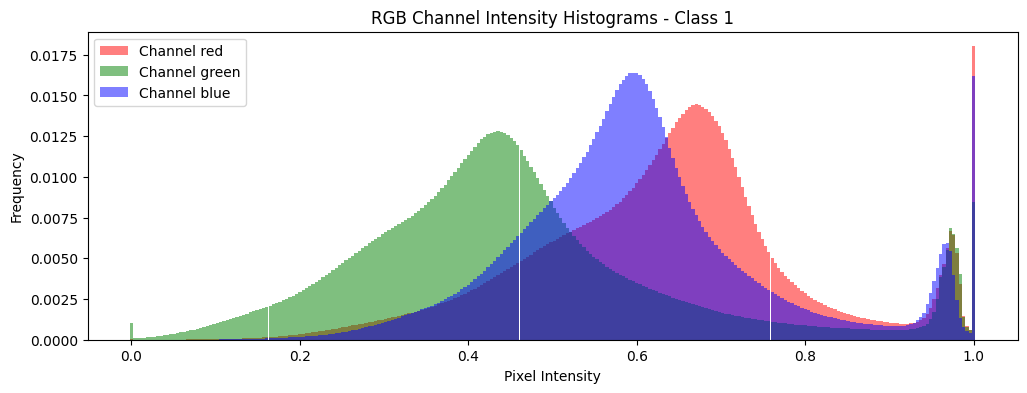

In [36]:
hists = get_channel_histograms_by_class(val_loader)

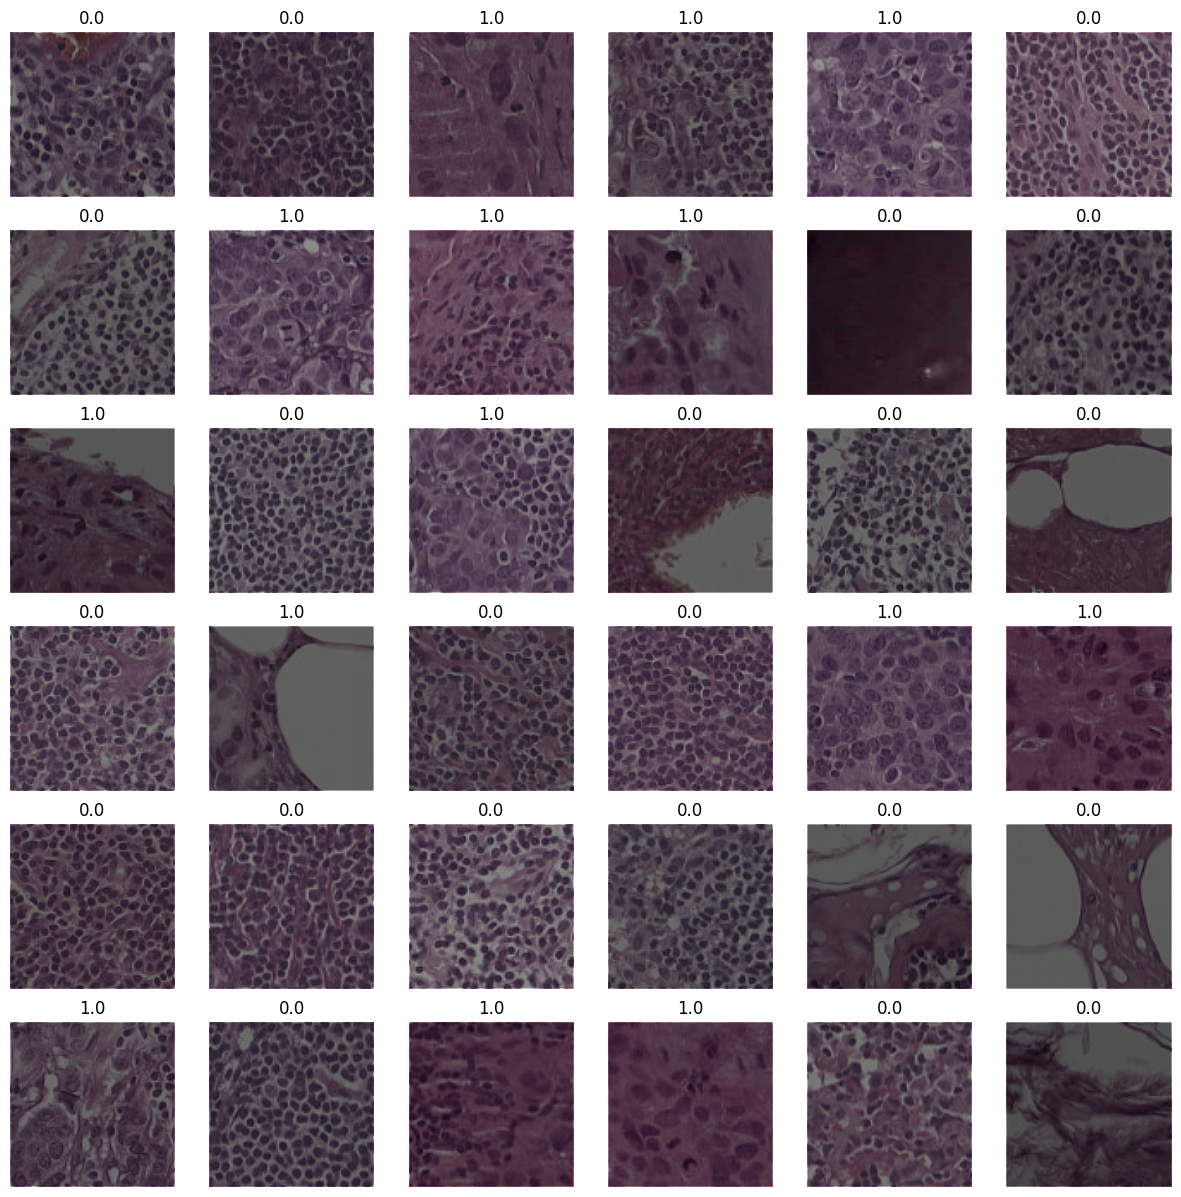

In [24]:
fig,axs = plt.subplots(6,6, figsize=(15,15))
for k,i in enumerate(np.random.choice(np.arange(len(val_set)), size = len(axs.flatten()), replace = False)):
    img, label = val_set.__getitem__(i)
    img = (img - img.min())/(img.max() - img.min())
    # print(np.moveaxis(img.numpy(), 0, -1))
    axs.flatten()[k].imshow(np.moveaxis(img.numpy(), 0, -1).astype(np.float32))
    axs.flatten()[k].set_title(str(label.item()))
    axs.flatten()[k].axis("off")
plt.show()

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')
feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
feature_extractor.eval()
print(feature_extractor.num_features)

Working on cuda.


Using cache found in /home/damemilien/.cache/torch/hub/facebookresearch_dinov2_main


384


In [42]:
import torch.nn as nn
linear_probing = torch.nn.Sequential(torch.nn.Linear(feature_extractor.num_features, 128),
                                    nn.ReLU(),
                                    torch.nn.Linear(128, 1),
                                     torch.nn.Sigmoid()).to(device)

In [43]:
linear_probing.load_state_dict(torch.load('/home/damemilien/Documents/best_model_bis.pth', weights_only=True))
linear_probing.eval()
linear_probing.to(device)
prediction_dict = {}

In [ ]:
from sklearn.metrics import confusion_matrix
import torch

def get_confusion_matrix(model, feature_extractor, dataloader, device, threshold=0.5):
    """
    Computes the confusion matrix for a binary classifier that outputs probabilities.

    Args:
        model (torch.nn.Module): Trained model that outputs probabilities.
        dataloader (torch.utils.data.DataLoader): DataLoader to evaluate on.
        device (torch.device): Device to run the model on.
        threshold (float): Decision threshold to binarize predictions.

    Returns:
        np.ndarray: 2x2 confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            probs = model(feature_extractor(x_batch.to(device))).squeeze(1)
            preds = (probs > threshold).int().cpu().numpy()
            labels = y_batch.int().cpu().numpy()

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    return confusion_matrix(all_labels, all_preds)


In [45]:
cm = get_confusion_matrix(linear_probing,feature_extractor,val_loader,device,0.5)

In [48]:
cm

array([[16135,  1317],
       [ 2738, 14714]])

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_brightness_distribution(dataloader, plot=True, use_perceptual=True):
    """
    Compute and return the brightness distribution for a dataset.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        plot (bool): Whether to plot the histogram.
        use_perceptual (bool): Use weighted RGB formula if True, else use raw average.

    Returns:
        brightness_values (list): List of brightness values for each image.
    """
    brightness_values = []

    for images, _ in tqdm(dataloader):
        # images: (B, 3, H, W)
        if use_perceptual:
            weights = torch.tensor([0.299, 0.587, 0.114], device=images.device).view(1, 3, 1, 1)
            grayscale = (images * weights).sum(dim=1)  # (B, H, W)
        else:
            grayscale = images.mean(dim=1)  # (B, H, W), average across RGB

        brightness_batch = grayscale.mean(dim=[1, 2])  # Average over H, W for each image
        brightness_values.extend(brightness_batch.cpu().numpy())

    if plot:
        plt.hist(brightness_values, bins=50, range=(0, 1), color='gray', alpha=0.7)
        plt.xlabel("Brightness")
        plt.ylabel("Number of Images")
        plt.title("Brightness Distribution")
        plt.grid(True)
        plt.show()

    return brightness_values


100%|██████████| 391/391 [01:31<00:00,  4.27it/s]


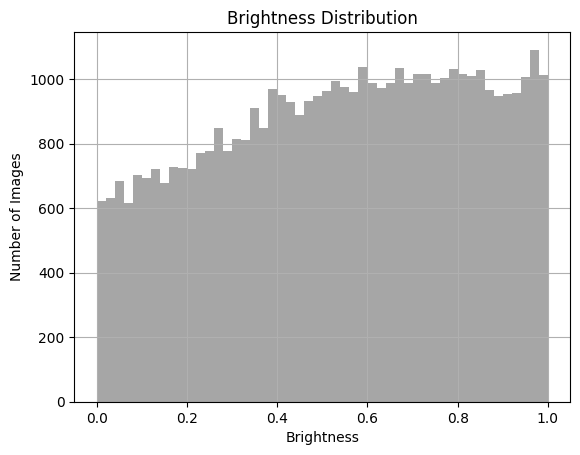

In [109]:
bd = compute_brightness_distribution(train_loader)

100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


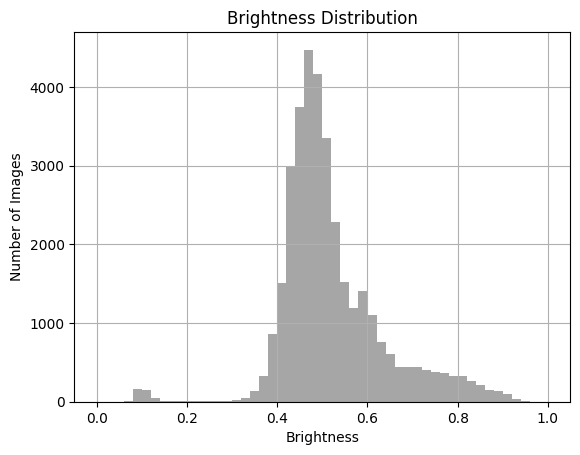

In [52]:
bd = compute_brightness_distribution(val_loader)

100%|██████████| 333/333 [01:09<00:00,  4.76it/s]


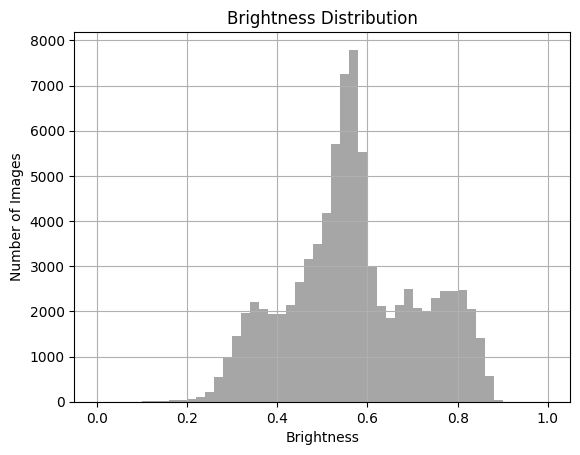

In [56]:
bd = compute_brightness_distribution(test_loader)